In [542]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
import random
from tqdm import tqdm
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [543]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

In [544]:
df = pd.read_csv('GNN_data/initial_MLP_data2.csv').drop(columns = ['Unnamed: 0'])
print(df.shape)
df.head(3)

(3600, 4)


,Input nodes,Output nodes,Train MSE,Test MSE
0,[2191 1457 1194 1113 130 1725 395 2300 535 ...,[ 303 41 939 2069 992 529 2731 1450 1333 ...,0.005877,0.483325
1,[2191 1457 1194 1113 130 1725 395 2300 535 ...,[ 562 2810 2338 2858 2546 454 2262 2617 125 ...,0.009230,0.560773
2,[2191 1457 1194 1113 130 1725 395 2300 535 ...,[ 414 1797 2200 1424 184 2150 2868 2660 92 ...,0.006478,0.419986


In [545]:
df_node_feats = pd.read_csv('Node_Features.csv').drop(columns = ['Node ID'])
print(df_node_feats.shape)
cols_to_norm = df_node_feats.columns[1:]
df_node_feats[cols_to_norm] = df_node_feats[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df_node_feats.head(3)

(2952, 7)


,Community ID,Degree,Betweeness,Eigenvector,Laplacian,Harmonic,Load
0,7,0.439516,0.012961,0.566034,0.355070,0.757463,0.010790
1,7,0.447581,0.010856,0.591562,0.367336,0.746456,0.009723
2,7,0.423387,0.049285,0.372795,0.307128,0.786978,0.049708


In [546]:
fly_mat = pd.read_csv('science.add9330_data_s1_to_s4/Supplementary-Data-S1/all-all_connectivity_matrix.csv').drop(columns=['Unnamed: 0'])
fly_mat = fly_mat.to_numpy()
fly_weights = pd.read_csv('GNN_data/Wx_initial_MLP_data.csv').drop(columns=['Unnamed: 0'])
fly_weights = fly_weights.to_numpy()

# Convert fly matrix into binary adjacency matrix
fly_mat[fly_mat > 0] = 1
fly_mat[fly_mat != 1] = 0
fly_mat[np.identity(fly_mat.shape[0], dtype=bool)] = 0.
fly_graph = fly_mat
print('fly density: ', np.sum(fly_mat.reshape(-1))/(fly_mat.shape[0]*fly_mat.shape[1]))

fly density:  0.012638989872283547


In [547]:
# Create a dummy graph dataset
# Replace with your own dataset loading and preprocessing code
def create_dummy_dataset(num_graphs, N_nodes, N_features):
    dataset = []
    for _ in range(num_graphs):
        x = torch.randn(N_nodes, N_features)  # Node features
        y = torch.randn(1, 1)  # Target value (per graph)
        # Create Data object and add it to the dataset
        graph_data = (x,y)
        dataset.append(graph_data)
    return dataset
def getGNNedData(df, nodeid_features_nparr):
    data = []
    for row in range(df.shape[0]):
        ins = [int(x) for x in df['Input nodes'].iloc[i].replace("[", "").replace("]", "").split()]
        outs = [int(x) for x in df['Output nodes'].iloc[i].replace("[", "").replace("]", "").split()]
        perf = torch.Tensor(df['Test MSE'].to_numpy())[row].reshape([1])
        graph_i_nfeats = np.zeros((fly_mat.shape[0], 2 + nodeid_features_nparr.shape[1] ))
        graph_i_nfeats[ins, 0] = 1
        graph_i_nfeats[outs, 1] = 1
        graph_i_nfeats[:, 2:] = nodeid_features_nparr
        data.append([torch.Tensor(graph_i_nfeats), perf])
    return data
def weight_matrix_to_edge_lists(adj_matrix):
    num_nodes = adj_matrix.shape[0]
    edge_list = [[],[]]
    weight_list = []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if adj_matrix[i][j] != 0:
                edge_list[0].append(i)
                edge_list[1].append(j)
                weight_list.append(adj_matrix[i, j])

    return edge_list, weight_list
# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, N_nodes, edge_index, edge_weight):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim, 1)
        self.fc2 = torch.nn.Linear(N_nodes, 1)
        self.edge_index = edge_index
        self.edge_weight = edge_weight

    def forward(self, x):
#         print(x.shape)
        x = self.conv1(x, self.edge_index, self.edge_weight)
        x = F.relu(x)
#         print(x.shape)
        x = self.conv2(x, self.edge_index, self.edge_weight)
        x = F.relu(x)
#         print(x.shape)
        x = self.fc1(x) # could use global pooling here? but because topology doesnt change, maybe fc can work
#         print(x.shape)
        x = self.fc2(x.flatten())
#         print(x.shape)
#         assert False
        return x

# Create dummy dataset
N_nodes, N_feats = 12, 16
data = create_dummy_dataset(20, N_nodes, N_feats)

edge_index = torch.tensor([[0, 0, 0, 3, 3, 1, 2, 3, 4, 1],
                           [1, 2, 3, 4, 5, 6, 7, 8, 9, 0]], dtype=torch.long)  # Adjacency matrix
edge_weight = abs(torch.randn(edge_index.shape[1]))  # Edge weights


# Set random seed for reproducibility
torch.manual_seed(42)
# Create GCN model
model = GCN(input_dim=N_feats, hidden_dim=32, N_nodes=N_nodes, edge_index=edge_index, edge_weight=edge_weight)
# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
model.train()
for epoch in range(10):
    total_loss = 0
    for datum in data:
        optimizer.zero_grad()
        output = model(datum[0])
        loss = criterion(output, datum[1])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(data)
    print(f"Epoch {epoch+1}: Average Loss: {avg_loss:.4f}")
# model.eval()

/opt/anaconda3/envs/RLenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1: Average Loss: 1.3273
Epoch 2: Average Loss: 0.8779
Epoch 3: Average Loss: 0.4196
Epoch 4: Average Loss: 0.1027
Epoch 5: Average Loss: 0.0370
Epoch 6: Average Loss: 0.1890
Epoch 7: Average Loss: 0.3543
Epoch 8: Average Loss: 0.0997
Epoch 9: Average Loss: 0.0598
Epoch 10: Average Loss: 0.0533


In [548]:
edge_index_fly, edge_weight_fly = weight_matrix_to_edge_lists(fly_mat)
edge_index_fly, edge_weight_fly = torch.tensor(edge_index_fly, dtype=torch.long), torch.Tensor(edge_weight_fly)

data2 = getGNNedData(df, df_node_feats.drop(columns = ['Community ID']))

In [549]:
data2 = random.sample(data2, len(data2))
N_tr, N_te  = 50, 10
assert N_tr + N_te < len(data2)
data_tr, data_te, data_superte = data2[:N_tr], data2[N_tr:N_tr + N_te], data2[N_tr + N_te:]
data_tr[0][0].shape

torch.Size([2952, 8])

In [557]:
data_tr[0][1]

tensor([0.3346])

In [561]:
data_tr[0][0][0]

tensor([0.0000, 0.0000, 0.4395, 0.0130, 0.5660, 0.3551, 0.7575, 0.0108])

In [536]:
N_nodes=data_tr[0][0].shape[0]
N_feats=data_tr[0][0].shape[1]
model = GCN(input_dim=N_feats, hidden_dim=fly_mat.shape[0]//5, N_nodes = N_nodes, 
            edge_index=edge_index_fly, edge_weight=edge_weight_fly)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

losses_tr, losses_te = [], []
training_preds, training_trues = [], []
for epoch in range(20):
    # Training loop
    model.train()
    with torch.enable_grad():
        total_loss = 0
        optimizer.zero_grad()
        for datum in tqdm(data_tr):
            output = model(datum[0])
            loss = criterion(output, datum[1])
            total_loss += loss
            training_preds.append(output)
            training_trues.append(datum[1])
        total_loss.backward()
        optimizer.step()
        avg_loss = total_loss.item() / len(data_tr)
        print(f"Epoch {epoch+1}: Average train Loss: {avg_loss:.4f}")
        losses_tr.append(avg_loss)
    
#     model.eval()
#     with torch.no_grad():
#         total_loss = 0
#         for datum in data_te:
#             output = model(datum[0])
#             loss = criterion(output, datum[1])
#             total_loss += loss.item()
#             testing_preds.append(output)
#         avg_loss = total_loss / len(data_te)
#         print(f"Epoch {epoch+1}: Average test Loss: {avg_loss:.4f}")
#         losses_te.append(avg_loss)

100%|███████████████████████████████████████████| 50/50 [00:19<00:00,  2.59it/s]


Epoch 1: Average train Loss: 0.2281


100%|███████████████████████████████████████████| 50/50 [00:17<00:00,  2.86it/s]


Epoch 2: Average train Loss: 468.8885


100%|███████████████████████████████████████████| 50/50 [00:17<00:00,  2.85it/s]


Epoch 3: Average train Loss: 5.7547


100%|███████████████████████████████████████████| 50/50 [00:18<00:00,  2.77it/s]


Epoch 4: Average train Loss: 15.4602


100%|███████████████████████████████████████████| 50/50 [00:19<00:00,  2.62it/s]


Epoch 5: Average train Loss: 73.8445


100%|███████████████████████████████████████████| 50/50 [00:18<00:00,  2.72it/s]


Epoch 6: Average train Loss: 35.4141


100%|███████████████████████████████████████████| 50/50 [00:17<00:00,  2.84it/s]


Epoch 7: Average train Loss: 0.3427


100%|███████████████████████████████████████████| 50/50 [00:17<00:00,  2.80it/s]


Epoch 8: Average train Loss: 27.4467


100%|███████████████████████████████████████████| 50/50 [00:17<00:00,  2.81it/s]


Epoch 9: Average train Loss: 13.6206


100%|███████████████████████████████████████████| 50/50 [00:17<00:00,  2.83it/s]


Epoch 10: Average train Loss: 0.8446


100%|███████████████████████████████████████████| 50/50 [00:17<00:00,  2.85it/s]


Epoch 11: Average train Loss: 1.7986


100%|███████████████████████████████████████████| 50/50 [00:24<00:00,  2.02it/s]


Epoch 12: Average train Loss: 5.9283


100%|███████████████████████████████████████████| 50/50 [00:18<00:00,  2.66it/s]


Epoch 13: Average train Loss: 7.0888


100%|███████████████████████████████████████████| 50/50 [00:18<00:00,  2.74it/s]


Epoch 14: Average train Loss: 5.1571


100%|███████████████████████████████████████████| 50/50 [00:17<00:00,  2.78it/s]


Epoch 15: Average train Loss: 2.2008


100%|███████████████████████████████████████████| 50/50 [00:17<00:00,  2.79it/s]


Epoch 16: Average train Loss: 0.2574


100%|███████████████████████████████████████████| 50/50 [00:17<00:00,  2.78it/s]


Epoch 17: Average train Loss: 0.3271


100%|███████████████████████████████████████████| 50/50 [00:17<00:00,  2.82it/s]


Epoch 18: Average train Loss: 1.7267


100%|███████████████████████████████████████████| 50/50 [00:18<00:00,  2.76it/s]


Epoch 19: Average train Loss: 2.5682


100%|███████████████████████████████████████████| 50/50 [00:17<00:00,  2.80it/s]


Epoch 20: Average train Loss: 2.1994


In [537]:
model.eval()
N_super = 100
with torch.no_grad():
    total_loss = 0
    for datum in data_superte[:N_super]:
        output = model(datum[0])
        loss = criterion(output, datum[1])
        total_loss += loss.item()
    avg_loss_super = total_loss / N_super
    print(f"Epoch {epoch+1}: Average test Loss: {avg_loss_super:.4f}")

Epoch 20: Average test Loss: 1.3231


In [538]:
a = list(split(training_preds, 20))
b = list(split(training_trues, 20))

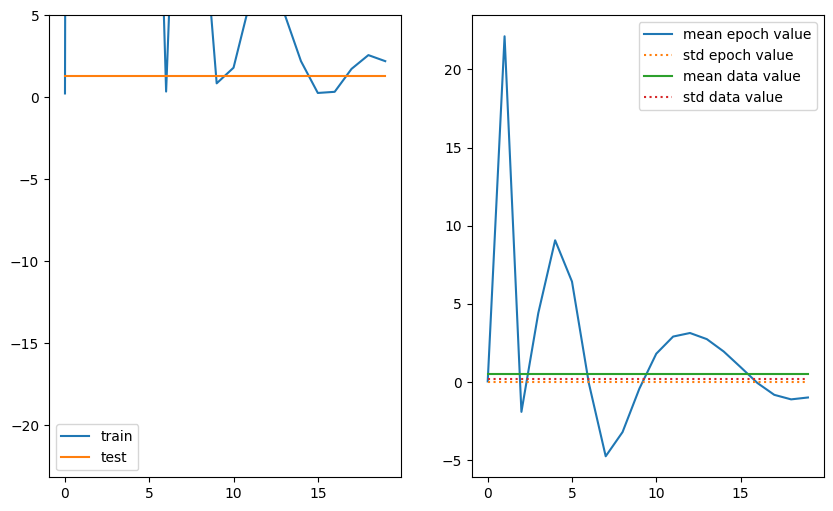

In [539]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 6))

ax[0].plot(losses_tr, label = 'train')
ax[0].plot(avg_loss_super*np.ones(len(losses_tr)), label = 'test')

ax[1].plot([torch.mean(torch.Tensor(x)) for x in a], label = 'mean epoch value')
ax[1].plot([torch.std(torch.Tensor(x)) for x in a], label = 'std epoch value', linestyle = ':')

ax[1].plot([torch.mean(torch.Tensor(x)) for x in b], label = 'mean data value')
ax[1].plot([torch.std(torch.Tensor(x)) for x in b], label = 'std data value', linestyle = ':')

ax[0].set_ylim([None, 5])
ax[0].legend()
ax[1].legend()

In [365]:
model.eval()
N_super = 100
with torch.no_grad():
    total_loss = 0
    for datum in data_superte[:N_super]:
        output = model(datum[0])
        loss = criterion(output, datum[1])
        total_loss += loss.item()
    avg_loss = total_loss / N_super
    print(f"Epoch {epoch+1}: Average test Loss: {avg_loss:.4f}")

Epoch 100: Average test Loss: 0.0567


In [436]:
model.eval()
N_super = 10
with torch.no_grad():
    for datum in data_superte[:N_super]:
        output = model(datum[0])
        print(output)

tensor([0.4950])
tensor([0.4950])
tensor([0.4950])
tensor([0.4950])
tensor([0.4950])
tensor([0.4950])
tensor([0.4950])
tensor([0.4950])
tensor([0.4950])
tensor([0.4950])


100%|███████████████████████████████████████████| 20/20 [07:21<00:00, 22.07s/it]


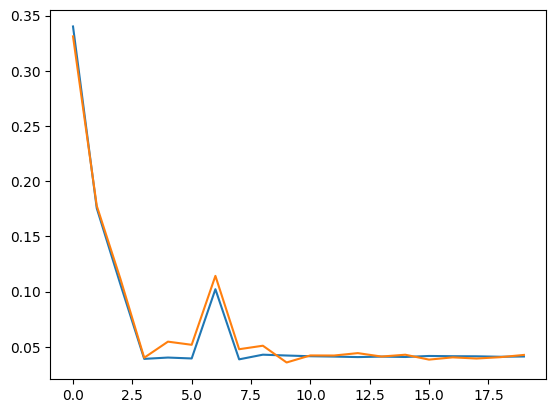

In [401]:
data2 = random.sample(data2, len(data2))
e1,e2 = [], []
for N_tr in tqdm(range(1000, 3000, 100)):
    N_tr, N_te  = N_tr, 500
    assert N_tr + N_te < len(data2)
    data_tr, data_te, data_superte = data2[:N_tr], data2[N_tr:N_tr + N_te], data2[N_tr + N_te:]
    data_tr[0][0].shape
    basic_trx, basic_try = np.array([x[0].numpy().reshape(-1) for x in data_tr]), np.array([x[1].numpy() for x in data_tr]).reshape(-1)
    basic_tex, basic_tey = np.array([x[0].numpy().reshape(-1) for x in data_te]), np.array([x[1].numpy() for x in data_te]).reshape(-1)

    mod = MLPRegressor()
    mod.fit(basic_trx, basic_try)
    
    pred = mod.predict(basic_trx)
    e1.append(mean_squared_error(pred, basic_try))
    pred = mod.predict(basic_tex)
    e2.append(mean_squared_error(pred, basic_tey))

plt.plot(e1)
plt.plot(e2)

In [407]:
mean_squared_error(np.mean(df['Test MSE'])*np.ones(len(df)), df['Test MSE'])


0.041486613895139815

In [393]:
pred = mod.predict(basic_tex)
mean_squared_error(pred, basic_tey)

0.4428062